Dataset: Two blobs


samples: 100%|██████████| 60/60 [00:00<00:00, 129.08it/s]


Dataset: Concentric circles


samples: 100%|██████████| 60/60 [00:00<00:00, 119.63it/s]


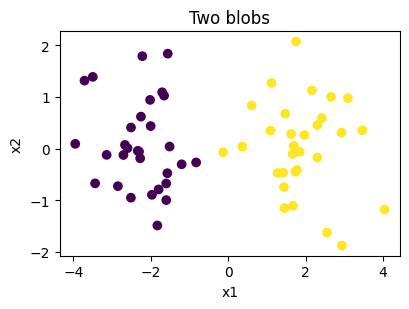

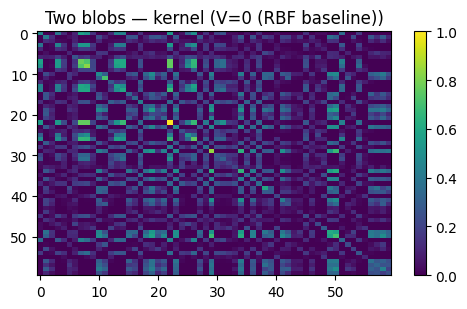

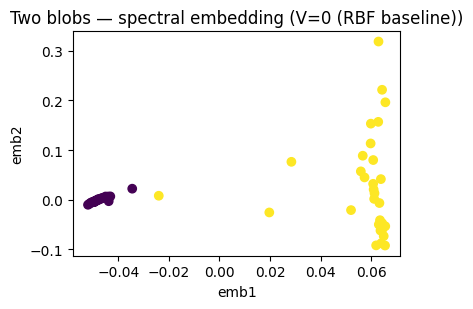

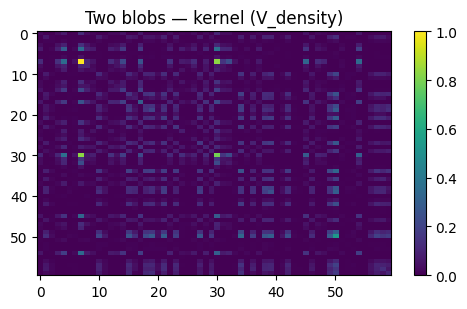

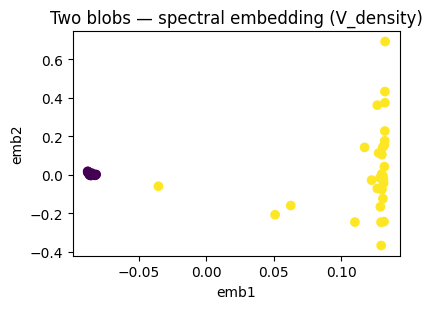

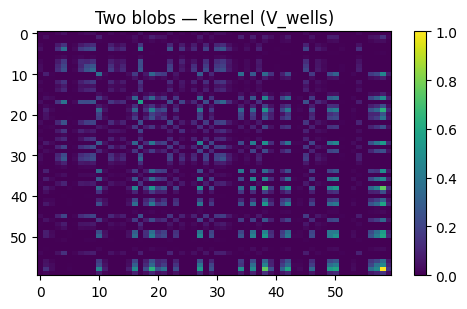

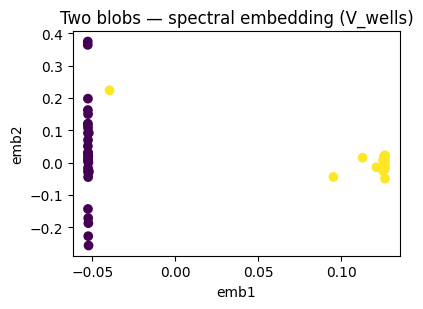

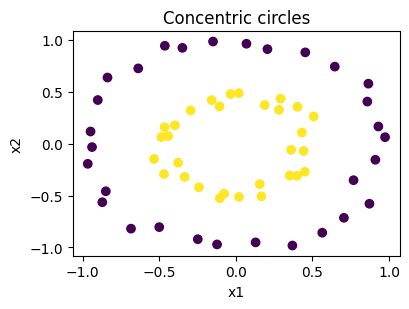

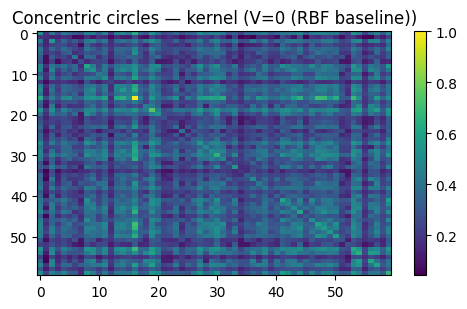

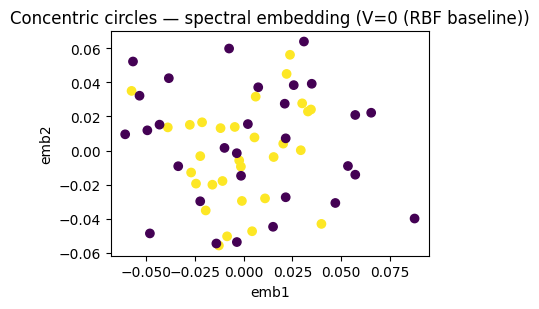

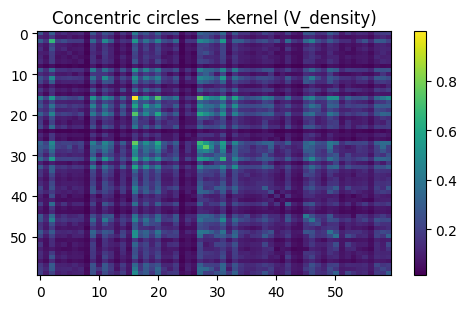

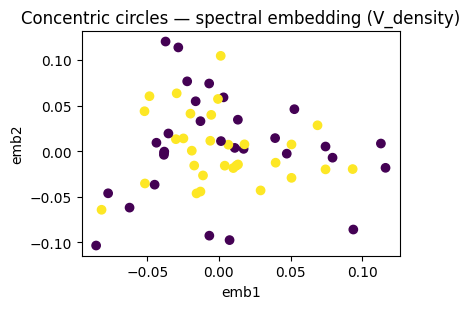

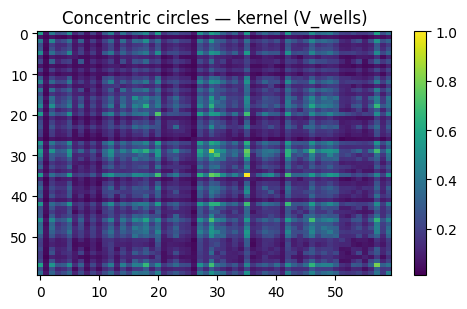

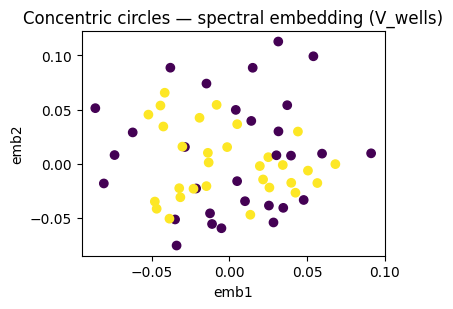

Done (very light demo).


In [ ]:
# Final lighter demo with landmarks and much smaller Monte-Carlo workload
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import SpectralEmbedding
from scipy.spatial.distance import cdist
from tqdm import trange

np.random.seed(1)

def simulate_paths_and_weights(x0, V_fun, T=1.0, Nsteps=15, Mpaths=40):
    d = x0.shape[0]
    dt = T / Nsteps
    sqrt_dt = np.sqrt(dt)
    endpoints = np.zeros((Mpaths, d))
    weights = np.zeros(Mpaths)
    for m in range(Mpaths):
        z = x0.copy()
        logw = 0.0
        for k in range(Nsteps):
            z = z + sqrt_dt * np.random.normal(size=d)
            logw += - V_fun(z) * dt
        endpoints[m] = z
        weights[m] = np.exp(logw)
    return endpoints, weights

def build_feature_from_endpoints(endpoints, weights, centers, sigma=0.25):
    D = cdist(endpoints, centers, 'sqeuclidean')
    G = np.exp(- D / (2 * sigma**2))
    feat = (weights[:, None] * G).sum(axis=0) / np.sqrt(len(weights))
    return feat

def approximate_kernel_matrix_landmarks(X, V_fun, centers, T=1.0, Nsteps=15, Mpaths=40, sigma=0.25):
    n, d = X.shape
    ncenters = centers.shape[0]
    Phi = np.zeros((n, ncenters))
    for i in trange(n, desc="samples"):
        endpoints, weights = simulate_paths_and_weights(X[i], V_fun, T=T, Nsteps=Nsteps, Mpaths=Mpaths)
        Phi[i] = build_feature_from_endpoints(endpoints, weights, centers, sigma=sigma)
    K = Phi @ Phi.T
    K = K / (np.max(np.abs(K)) + 1e-12)
    return K, Phi

#####################
# Datasets (smaller)
#####################
n_points = 60
X1, y1 = make_blobs(n_samples=n_points, centers=[[-2,0],[2,0]], cluster_std=0.8, random_state=2)
X2, y2 = make_circles(n_samples=n_points, factor=0.5, noise=0.05, random_state=3)
datasets = [("Two blobs", X1, y1), ("Concentric circles", X2, y2)]

#####################
# Potentials         #
#####################

def V_zero_factory():
    return lambda x: 0.0

def V_density_knn_factory(X, k=6, lam=5.0):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)
    dists, idx = nbrs.kneighbors(X)
    mean_d = dists[:,1:].mean(axis=1)
    dens_proxy = 1.0 / (mean_d + 1e-12)
    dmin, dmax = dens_proxy.min(), dens_proxy.max()
    def V(x):
        x = np.atleast_2d(x)
        dists_x, _ = nbrs.kneighbors(x, n_neighbors=k+1)
        md = dists_x[:,1:].mean(axis=1)
        dp = 1.0 / (md + 1e-12)
        dp_norm = (dp - dmin) / (dmax - dmin + 1e-12)
        return float(lam * (1.0 - dp_norm[0]))
    return V

def V_wells_factory(centers, a=1.0):
    centers = np.asarray(centers)
    def V(x):
        x = np.atleast_1d(x)
        D2 = np.sum((x - centers)**2, axis=1)
        return float(a * np.min(D2))
    return V

results = []
for name, X, y in datasets:
    print("Dataset:", name)
    V0 = V_zero_factory()
    Vdens = V_density_knn_factory(X, k=6, lam=5.0)
    # landmarks: choose m random points as centers for features (Nystrom-like)
    m_landmarks = 20
    rng = np.random.default_rng(0)
    idx = rng.choice(len(X), size=m_landmarks, replace=False)
    centers = X[idx]
    # wells at cluster centers
    if name == "Two blobs":
        wells_centers = np.array([[-2,0],[2,0]])
    else:
        wells_centers = np.array([X[y==0].mean(axis=0), X[y==1].mean(axis=0)])
    Vwells = V_wells_factory(wells_centers, a=2.0)

    K0, _ = approximate_kernel_matrix_landmarks(X, V0, centers, T=1.0, Nsteps=15, Mpaths=40, sigma=0.25)
    Kd, _ = approximate_kernel_matrix_landmarks(X, Vdens, centers, T=1.0, Nsteps=15, Mpaths=40, sigma=0.25)
    Kw, _ = approximate_kernel_matrix_landmarks(X, Vwells, centers, T=1.0, Nsteps=15, Mpaths=40, sigma=0.25)
    results.append({"name": name, "X": X, "y": y, "K_zero": K0, "K_density": Kd, "K_wells": Kw})

# Visualization
for res in results:
    X = res["X"]; y = res["y"]; name = res["name"]
    plt.figure(figsize=(4.2,3.2))
    plt.title(name)
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

    for title, K in [("V=0 (RBF baseline)", res["K_zero"]), ("V_density", res["K_density"]), ("V_wells", res["K_wells"])]:
        plt.figure(figsize=(5,3.2))
        plt.title(f"{name} — kernel ({title})")
        plt.imshow(K, aspect='auto')
        plt.colorbar()
        plt.tight_layout()
        plt.show()

        Ke = (K + K.T) / 2.0
        se = SpectralEmbedding(n_components=2, affinity='precomputed')
        emb = se.fit_transform(Ke)
        plt.figure(figsize=(4.2,3.2))
        plt.title(f"{name} — spectral embedding ({title})")
        plt.scatter(emb[:,0], emb[:,1], c=y)
        plt.xlabel("emb1"); plt.ylabel("emb2")
        plt.tight_layout()
        plt.show()

print("Done (very light demo).")


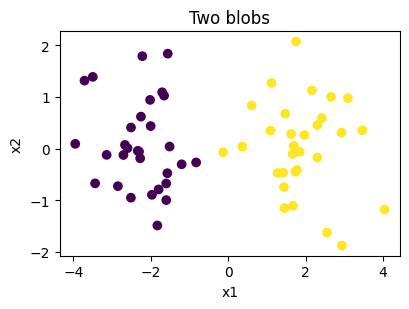

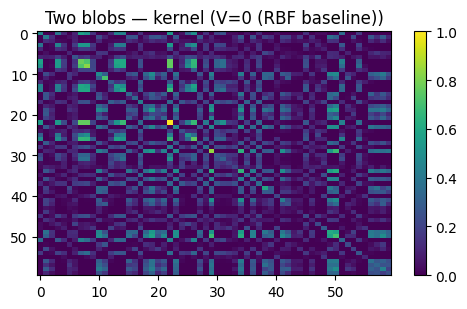

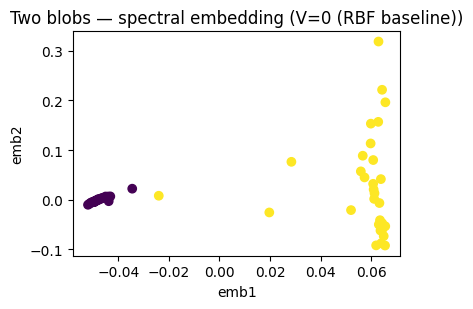


Dataset: Two blobs
Kernel type: V=0 (RBF baseline)
Accuracy: 1.000,  F1-score: 1.000


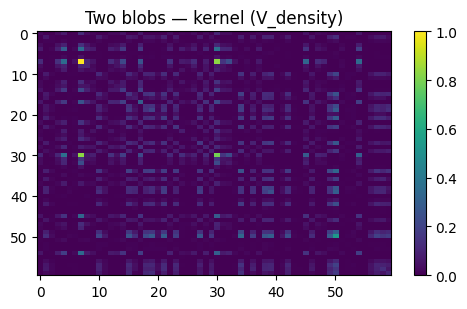

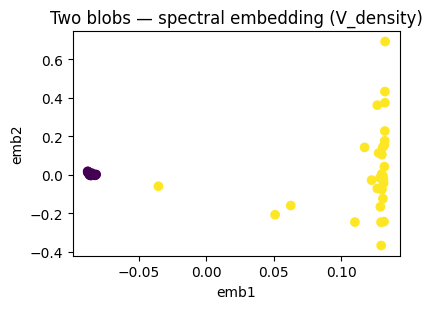


Dataset: Two blobs
Kernel type: V_density
Accuracy: 0.750,  F1-score: 0.745


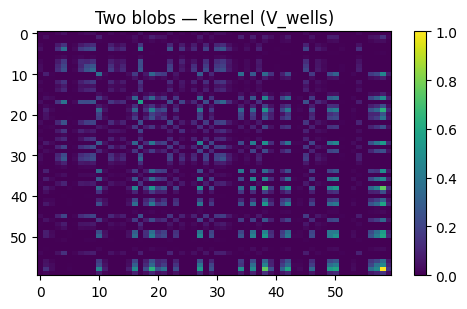

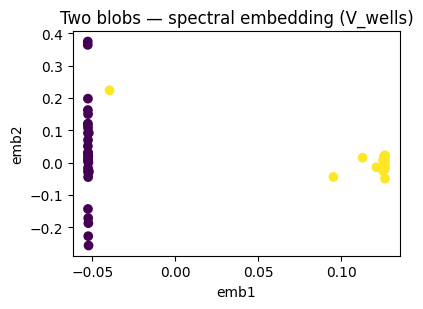


Dataset: Two blobs
Kernel type: V_wells
Accuracy: 0.833,  F1-score: 0.829


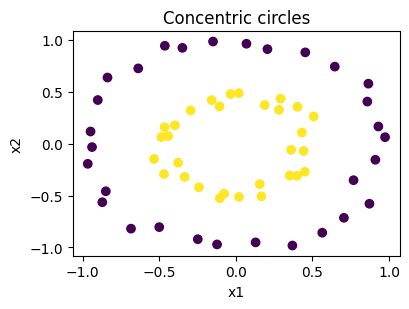

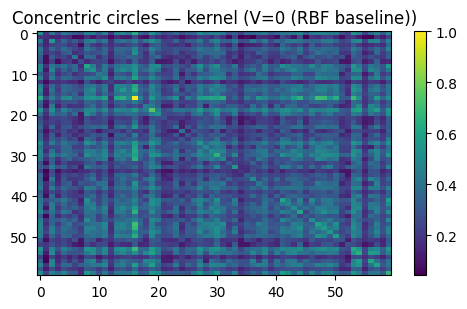

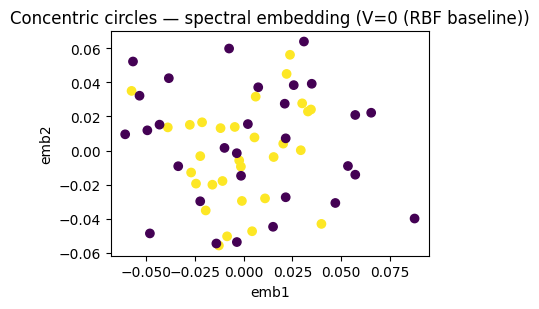


Dataset: Concentric circles
Kernel type: V=0 (RBF baseline)
Accuracy: 0.250,  F1-score: 0.100


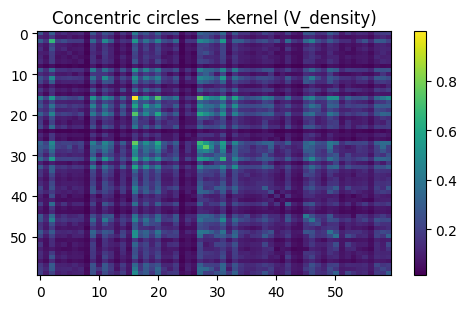

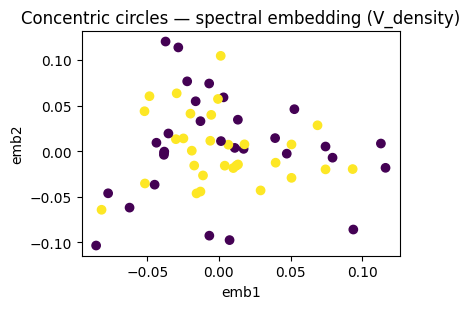


Dataset: Concentric circles
Kernel type: V_density
Accuracy: 0.500,  F1-score: 0.500


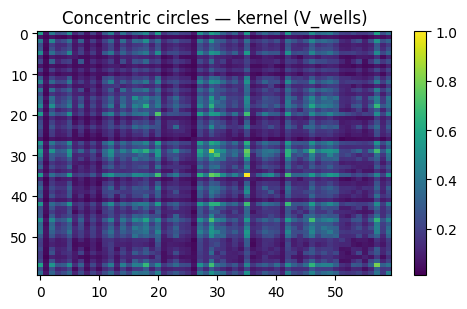

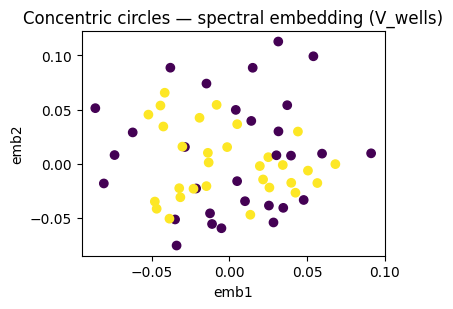


Dataset: Concentric circles
Kernel type: V_wells
Accuracy: 0.917,  F1-score: 0.923

All evaluations complete.


In [2]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

# Visualization + classification
for res in results:
    X = res["X"]; y = res["y"]; name = res["name"]
    plt.figure(figsize=(4.2,3.2))
    plt.title(name)
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

    for title, K in [("V=0 (RBF baseline)", res["K_zero"]),
                     ("V_density", res["K_density"]),
                     ("V_wells", res["K_wells"])]:

        plt.figure(figsize=(5,3.2))
        plt.title(f"{name} — kernel ({title})")
        plt.imshow(K, aspect='auto')
        plt.colorbar()
        plt.tight_layout()
        plt.show()

        # Spectral embedding visualization
        Ke = (K + K.T) / 2.0
        se = SpectralEmbedding(n_components=2, affinity='precomputed')
        emb = se.fit_transform(Ke)
        plt.figure(figsize=(4.2,3.2))
        plt.title(f"{name} — spectral embedding ({title})")
        plt.scatter(emb[:,0], emb[:,1], c=y)
        plt.xlabel("emb1"); plt.ylabel("emb2")
        plt.tight_layout()
        plt.show()

        # --- Classification using SVM with precomputed kernel ---
        # Simple 80/20 train/test split
        n = len(y)
        idx = np.arange(n)
        np.random.shuffle(idx)
        split = int(0.8 * n)
        train_idx, test_idx = idx[:split], idx[split:]

        K_train = K[np.ix_(train_idx, train_idx)]
        K_test = K[np.ix_(test_idx, train_idx)]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = SVC(kernel='precomputed')
        clf.fit(K_train, y_train)
        y_pred = clf.predict(K_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"\nDataset: {name}")
        print(f"Kernel type: {title}")
        print(f"Accuracy: {acc:.3f},  F1-score: {f1:.3f}")

print("\nAll evaluations complete.")


Dataset: Two blobs


samples:   0%|          | 0/60 [00:00<?, ?it/s]

samples: 100%|██████████| 60/60 [00:01<00:00, 45.73it/s]


Dataset: Concentric circles


samples: 100%|██████████| 60/60 [00:01<00:00, 51.10it/s]


Dataset: Moons


samples: 100%|██████████| 60/60 [00:01<00:00, 45.47it/s]


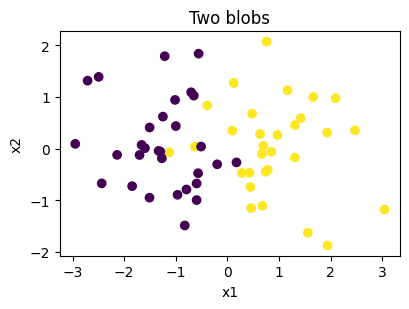


Dataset: Two blobs
Classic SVM baselines on raw features:
  RBF SVM   -> Accuracy: 0.833, F1-weighted: 0.838
  Linear SVM-> Accuracy: 0.833, F1-weighted: 0.838
  Poly SVM  -> Accuracy: 0.833, F1-weighted: 0.838

Kernel type: V=0 (RBF baseline)
  Precomputed-kernel SVM -> Accuracy: 0.750, F1-weighted: 0.755

Kernel type: V_density
  Precomputed-kernel SVM -> Accuracy: 0.833, F1-weighted: 0.838

Kernel type: V_wells
  Precomputed-kernel SVM -> Accuracy: 0.667, F1-weighted: 0.667


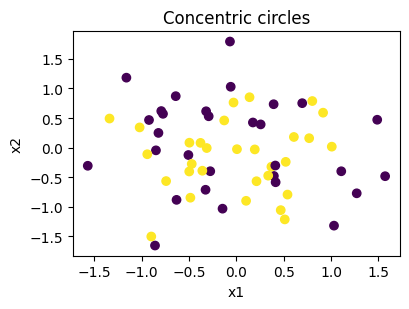


Dataset: Concentric circles
Classic SVM baselines on raw features:
  RBF SVM   -> Accuracy: 0.417, F1-weighted: 0.378
  Linear SVM-> Accuracy: 0.583, F1-weighted: 0.580
  Poly SVM  -> Accuracy: 0.583, F1-weighted: 0.496

Kernel type: V=0 (RBF baseline)
  Precomputed-kernel SVM -> Accuracy: 0.750, F1-weighted: 0.733

Kernel type: V_density
  Precomputed-kernel SVM -> Accuracy: 0.500, F1-weighted: 0.486

Kernel type: V_wells
  Precomputed-kernel SVM -> Accuracy: 0.583, F1-weighted: 0.580


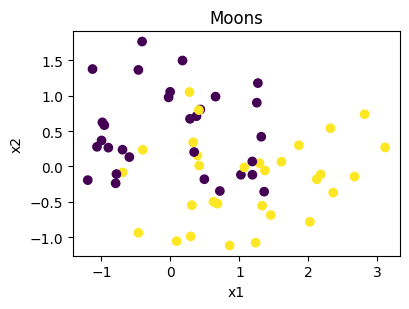


Dataset: Moons
Classic SVM baselines on raw features:
  RBF SVM   -> Accuracy: 0.750, F1-weighted: 0.744
  Linear SVM-> Accuracy: 0.750, F1-weighted: 0.744
  Poly SVM  -> Accuracy: 0.833, F1-weighted: 0.833

Kernel type: V=0 (RBF baseline)
  Precomputed-kernel SVM -> Accuracy: 0.583, F1-weighted: 0.586

Kernel type: V_density
  Precomputed-kernel SVM -> Accuracy: 0.500, F1-weighted: 0.471

Kernel type: V_wells
  Precomputed-kernel SVM -> Accuracy: 0.417, F1-weighted: 0.245

All evaluations complete.


In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs, make_circles, make_moons

# Visualization + classification (extended to include classic SVMs)
n_points = 60
X1, y1 = make_blobs(n_samples=n_points, centers=[[-1,0],[1,0]], cluster_std=0.8, random_state=2)
X2, y2 = make_circles(n_samples=n_points, factor=0.2, noise=0.6, random_state=3)
X3, y3 = make_moons(n_samples=n_points, noise=0.5, random_state=4)
datasets = [("Two blobs", X1, y1), ("Concentric circles", X2, y2), ("Moons", X3, y3)]

results = []
for name, X, y in datasets:
    print("Dataset:", name)
    V0 = V_zero_factory()
    Vdens = V_density_knn_factory(X, k=6, lam=5.0)
    # landmarks: choose m random points as centers for features (Nystrom-like)
    m_landmarks = 20
    rng = np.random.default_rng(0)
    idx = rng.choice(len(X), size=m_landmarks, replace=False)
    centers = X[idx]
    # wells at cluster centers
    if name == "Two blobs":
        wells_centers = np.array([[-2,0],[2,0]])
    else:
        wells_centers = np.array([X[y==0].mean(axis=0), X[y==1].mean(axis=0)])
    Vwells = V_wells_factory(wells_centers, a=2.0)

    K0, _ = approximate_kernel_matrix_landmarks(X, V0, centers, T=1.2, Nsteps=40, Mpaths=40, sigma=0.25)
    Kd, _ = approximate_kernel_matrix_landmarks(X, Vdens, centers, T=1.2, Nsteps=40, Mpaths=40, sigma=0.25)
    Kw, _ = approximate_kernel_matrix_landmarks(X, Vwells, centers, T=1.2, Nsteps=40, Mpaths=40, sigma=0.25)
    results.append({"name": name, "X": X, "y": y, "K_zero": K0, "K_density": Kd, "K_wells": Kw})

for res in results:
    X = res["X"]; y = res["y"]; name = res["name"]
    plt.figure(figsize=(4.2,3.2))
    plt.title(name)
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.tight_layout()
    plt.show()

    # Use a single randomized split per dataset for fair comparisons across kernels/models
    n = len(y)
    rng = np.random.default_rng(42)
    idx = np.arange(n)
    rng.shuffle(idx)
    split = int(0.8 * n)
    train_idx, test_idx = idx[:split], idx[split:]

    X_train_raw, X_test_raw = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # scale for classic SVMs
    scaler = StandardScaler().fit(X_train_raw)
    X_train = scaler.transform(X_train_raw)
    X_test = scaler.transform(X_test_raw)

    # Classic SVM baselines on raw features
    # RBF SVM
    clf_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
    clf_rbf.fit(X_train, y_train)
    y_pred_rbf = clf_rbf.predict(X_test)
    acc_rbf = accuracy_score(y_test, y_pred_rbf)
    f1_rbf = f1_score(y_test, y_pred_rbf, average='weighted')

    # Linear SVM
    clf_lin = SVC(kernel='linear', C=1.0)
    clf_lin.fit(X_train, y_train)
    y_pred_lin = clf_lin.predict(X_test)
    acc_lin = accuracy_score(y_test, y_pred_lin)
    f1_lin = f1_score(y_test, y_pred_lin, average='weighted')

    # Polynomial SVM
    clf_poly = SVC(kernel='poly', degree=3, C=1.0, gamma='scale')
    clf_poly.fit(X_train, y_train)
    y_pred_poly = clf_poly.predict(X_test)
    acc_poly = accuracy_score(y_test, y_pred_poly)
    f1_poly = f1_score(y_test, y_pred_poly, average='weighted')

    print(f"\nDataset: {name}")
    print("Classic SVM baselines on raw features:")
    print(f"  RBF SVM   -> Accuracy: {acc_rbf:.3f}, F1-weighted: {f1_rbf:.3f}")
    print(f"  Linear SVM-> Accuracy: {acc_lin:.3f}, F1-weighted: {f1_lin:.3f}")
    print(f"  Poly SVM  -> Accuracy: {acc_poly:.3f}, F1-weighted: {f1_poly:.3f}")

    # Now evaluate each FK-derived kernel with precomputed-kernel SVM
    for title, K in [("V=0 (RBF baseline)", res["K_zero"]),
                     ("V_density", res["K_density"]),
                     ("V_wells", res["K_wells"])]:
        """
        plt.figure(figsize=(5,3.2))
        plt.title(f"{name} — kernel ({title})")
        plt.imshow(K, aspect='auto')
        plt.colorbar()
        plt.tight_layout()
        plt.show()

        # Spectral embedding visualization
        Ke = (K + K.T) / 2.0
        se = SpectralEmbedding(n_components=2, affinity='precomputed')
        emb = se.fit_transform(Ke)
        plt.figure(figsize=(4.2,3.2))
        plt.title(f"{name} — spectral embedding ({title})")
        plt.scatter(emb[:,0], emb[:,1], c=y)
        plt.xlabel("emb1"); plt.ylabel("emb2")
        plt.tight_layout()
        plt.show()
        """
        # --- Classification using SVM with precomputed FK kernel ---
        K_train = K[np.ix_(train_idx, train_idx)]
        K_test = K[np.ix_(test_idx, train_idx)]

        clf = SVC(kernel='precomputed', C=1.0)
        clf.fit(K_train, y_train)
        y_pred = clf.predict(K_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        print(f"\nKernel type: {title}")
        print(f"  Precomputed-kernel SVM -> Accuracy: {acc:.3f}, F1-weighted: {f1:.3f}")

print("\nAll evaluations complete.")
